# Lab 08: Regression Models (2 Bonus Points Possible)

This lab is presented with some revisions from [Dennis Sun at Cal Poly](https://web.calpoly.edu/~dsun09/index.html) and his [Data301 Course](http://users.csc.calpoly.edu/~dsun09/data301/lectures.html)

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)

In [1]:
# first, mount your google drive, change to the course folder, pull latest changes, and change to the lab folder.
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/cmps3160
# !git pull
%cd _labs/Lab08

Mounted at /content/drive
/content/drive/My Drive/cmps3160
/content/drive/My Drive/cmps3160/_labs/Lab08


Prediction problems are ubiquitous in real world applications. For example:

- A real estate agent might want to predict the fair price of a home, using features of the home.
- A sports bettor might want to predict which team will win the game, using information about the teams.
- A historian might want to predict which historical figure wrote an anonymous document, using the words in the document.

In each case, we have two kinds of variables:

- **features** (a.k.a. **predictors**, **inputs**, **independent variables**), such as square footage and number of bedrooms, that are used to predict 
- a **label** (a.k.a. **response**, **output**, **dependent variable**), such as house price. 

We can formalize the problem mathematically as follows: let ${\bf x}$ be the features and $y$ the label; a **predictive model** is a function $f$ that maps ${\bf x}$ to $y$:

$$ f: {\bf x} \mapsto y. $$

Now suppose we have a new house, with features ${\bf x}^*$. A predictive model $f$ predicts the price of this house to be $f({\bf x}^*)$.

How do we come up a predictive model $f$ in the first place? One way is to learn it from existing data, or **training data**. For example, to build a model that predicts the price of a home from the square footage (`Gr Liv Area`), we would need training data like the points shown in black below.

<img src="https://github.com/nmattei/cmps3160/blob/master/_labs/images/predictive_model.png?raw=1" />

We could then learn a model, $f$, from this training data. For example, one possible predictive model is the red curve shown in the plot. This model was chosen to fit the points in the training data as tightly as possible. If we wanted to predict the price of a 2700 square foot home using this model, we would simply evaluate $f(2700)$, which comes out to about \\$300,000. The key thing to note is that $f$ depends on the training data. If the training data changes, then so does $f$.

The process of learning predictive models from data is known as **machine learning**. There are many ways to learn a predictive model from data, including _linear regression_ (which you may have seen in a statistics course), _decision trees_, and _neural networks_. In this chapter, we will focus on one machine learning algorithm called **k-nearest neighbors** that leverages the distance metrics between observations we talked about in class.

Predictive models are divided into two types, depending on whether the label $y$ is categorical or quantitative. If the label is quantitative, then the prediction problem is a **regression** problem, and the model is called a **regressor**. If the label is categorical, then the prediction problem is a **classification** problem, and the model is called a **classifier**.  We'll look at both of these models in the next couple of labs.

# Part 1:  K-Nearest Neighbors for Regression

_Regressors_ are predictive models that are employed when the label is quantitative. In this section, we will train a machine learning model that predicts the price of a house from its square footage and other features.

We will use the Ames housing data set as the training data. First, let's read in the data set.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 5

housing = pd.read_csv("../data/ames.tsv", sep="\t")
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Let's focus on just two features for now: square footage (of the dwelling) and the number of bedrooms. Let's plot the training data, using a color gradient to represent the labels. Notice how we can customize the color gradient using the `cmap=` argument. A list of the available colormaps can be found [here](https://matplotlib.org/examples/color/colormaps_reference.html).

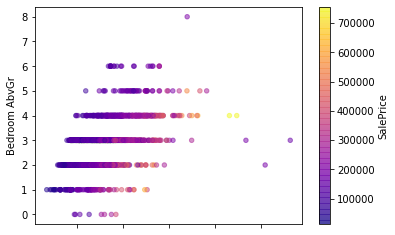

In [3]:
housing.plot.scatter(x="Gr Liv Area", y="Bedroom AbvGr", 
                     c="SalePrice", cmap="plasma", alpha=.5);

Notice how points that are close on this plot tend to have similar house prices. This insight is the basis of the $k$-nearest neighbors algorithm for predicting house prices. Suppose that we want to predict the price of a 4000 square foot home with 3 bedrooms, represented by a black circle on the plot below.

<img src="https://github.com/nmattei/cmps3160/blob/master/_labs/images/regression.png?raw=1" />

We can find the $k$ points that are closest to this point in feature space and average their prices as our prediction. For example, the 30-nearest neighbors in the training data to the new home are illustrated in the plot below. We would average the prices of these 30 homes to obtain the predicted price for the new home.

<img src="https://github.com/nmattei/cmps3160/blob/master/_labs/images/regression_neighbors.png?raw=1" />

The $k$-nearest neighbors regression algorithm can be summarized as follows:

1. Determine the $k$ closest points in the training data to the new point that you want to predict for, based on some distance metric on the features.
2. The predicted label of the new point is the mean (or median) of the labels of the $k$ closest points.

Let's see how to implement this in code. First, we extract the training data and scale the features using z-scores as we discussed in class:

In [4]:
X_train = housing[["Gr Liv Area", "Bedroom AbvGr"]]
y_train = housing["SalePrice"]

X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_sc = (X_train - X_train_mean) / X_train_std

Then, we create a `Series` for the new house, scaling it in exactly the same way:

In [5]:
x_new = pd.Series(dtype=float)
x_new["Gr Liv Area"] = 4000
x_new["Bedroom AbvGr"] = 3

x_new_sc = (x_new - X_train_mean) / X_train_std
x_new_sc

Gr Liv Area      4.946124
Bedroom AbvGr    0.176064
dtype: float64

Now we calculate the (Euclidean) distances between this new house and each house in the training data. Then, we sort the distances.

Calculating the distance between two points is not as straightforward as it might seem because there is more than one way to define distance. The one most familiar to you is probably **Euclidan distance**, which is the straight-line distance ("as the crow flies") between the two points. The formula for calculating this distance is a generalization of the Pythagorean theorem:

$$ d({\bf x}, {\bf x'}) = \sqrt{\sum_{j=1}^D (x_j - x'_j)^2} $$

In [6]:
dists = np.sqrt(((X_train_sc - x_new_sc) ** 2).sum(axis=1))
dists_sorted = dists.sort_values()
dists_sorted

1306    1.002950
2181    1.337266
          ...   
1302    7.507162
1901    7.644028
Length: 2930, dtype: float64

The first 30 entries of this sorted list are the 30 nearest neighbors. Let's get their indices.

In [7]:
i_nearest = dists_sorted.index[:30]
i_nearest

Int64Index([1306, 2181, 1767, 2445, 2666, 1760, 2450, 1537, 2045,   15,   65,
            1772,  565, 2214,  422, 2336, 1182, 2570, 1945, 1764, 2500, 2453,
            2329, 1320, 1497, 2180, 1572, 2737, 2218, 1022],
           dtype='int64')

Now we can look up these indices in the original data.

In [8]:
housing.loc[i_nearest]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1306,1307,902207220,75,RM,87.0,18386,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,295000
2181,2182,908154205,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,2219,909281130,70,RL,70.0,10570,Pave,NaN,Reg,Bnk,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,315000
1022,1023,527325070,60,RL,NaN,12227,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,272000


To make a prediction for the price of this new house, we average the sale prices of these 30 nearest neighbors.

In [9]:
y_train.loc[i_nearest].mean()

382429.23333333334

So the model predicts that the house is worth $382,429.

## A More Complex Model

The model above only had two features so it was easy to visualize the "nearest neighbors" on the scatterplot. But the magic of $k$-nearest neighbors is that it still works when there are more features and the data isn't so easy to visualize.

Let's create a model that has 8 features, some of which are categorical.

In [10]:
# Create a new variable
housing["Date Sold"] = housing["Yr Sold"] + housing["Mo Sold"] / 12
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Date Sold",
            "Neighborhood"]

# Note that "Neighborhood" is a categorical variable.
X_train = pd.get_dummies(housing[features])
y_train = housing["SalePrice"]

Suppose an assessor is trying to predict the fair value in 2011 of a 1400-square foot home built in 1980 with 3 bedrooms, 2 full baths, and 1 half bath, on a 9000 square-foot lot in the `OldTown` neighborhood. Let's create the `pandas` `Series` corresponding to this house. Remember that we have dummy variables for each neighborhood. We have to be sure to include these dummy variables in the new `Series` as well. The easiest way to do this is to initialize the index of the `Series` to match the columns of `X_train` above.

In [11]:
X_train.columns

Index(['Lot Area', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Year Built', 'Date Sold', 'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker'],
      dtype='object')

In [12]:
# Initialize a Series of NaNs, indexed by the columns of X_train
x_new = pd.Series(index=X_train.columns, dtype=float)

# Set the values of the known variables.
x_new["Lot Area"] = 9000
x_new["Gr Liv Area"] = 1400
x_new["Full Bath"] = 2
x_new["Half Bath"] = 1
x_new["Bedroom AbvGr"] = 3
x_new["Year Built"] = 1980
x_new["Date Sold"] = 2011

# This house is in Old Town, so its dummy variable has value 1.
x_new["Neighborhood_OldTown"] = 1
# The dummy variables for the other neighborhoods all have value 0.
x_new.fillna(0, inplace=True)

x_new

Lot Area                9000.0
Gr Liv Area             1400.0
                         ...  
Neighborhood_Timber        0.0
Neighborhood_Veenker       0.0
Length: 35, dtype: float64

Now we can implement $k$-nearest neighbors much as we did above.

In [13]:
# Standardize the variables.
X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train_sc = (X_train - X_train_mean) / X_train_std
x_new_sc = (x_new - X_train_mean) / X_train_std

# Find index of 30 nearest neighbors.
dists = np.sqrt(((X_train_sc - x_new_sc) ** 2).sum(axis=1))
i_nearest = dists.sort_values()[:30].index

# Average the labels of these 30 nearest neighbors
y_train.loc[i_nearest].mean()

132343.33333333334

So the model predicts that this house is worth \$132,343.

## The K-Nearest Neighbors Regression Function

Remember that a predictive model is a function $f: {\bf x} \mapsto y$. We can visualize $f$ when ${\bf x}$ consists of a single feature, like square footage. We saw a hypothetical predictive model in Figure 5.1 above. What does $f$ look like when the model is a $k$-nearest neighbors regressor?

First, we extract the training data. There is no need to scale the features in this case because there is only one feature. (The point of scaling is to bring all of the variables to the same scale.

In [14]:
X_train = housing[["Gr Liv Area"]]
y_train = housing["SalePrice"]

In order to plot $f$, we need to evaluate the predictive model at a grid of feature values. Since square footage varies from 0 to 6000 square feet in the training data, we create a grid of ${\bf x}$ values from 0 to 6000, in increments of 10.

In [15]:
X_new = pd.DataFrame()
X_new["Gr Liv Area"] = np.arange(0, 6000, 10)
X_new

,Gr Liv Area
0,0
1,10
...,...
598,5980
599,5990


Next, we will define a function `get_30NN_prediction` that implements the 30-nearest neighbor algorithm above: given a new observation, it returns the mean label of the 30-nearest neighbors to that observation.

In [16]:
def get_30NN_prediction(x_new):
    """Given new observation, returns 30-nearest neighbors prediction
    """
    dists = np.sqrt(((X_train - x_new)**2).sum(axis=1))
    inds_sorted = dists.sort_values().index[:30]
    return y_train.loc[inds_sorted].mean()

We actually have 600 new observations in `X_new`. Let's apply this function to each new observation.

In [17]:
y_new_pred = X_new.apply(get_30NN_prediction, axis=1)
y_new_pred

0       72010.366667
1       72010.366667
           ...      
598    372458.466667
599    372458.466667
Length: 600, dtype: float64

We want to plot these predictions as a curve (`.plot.line()`). `pandas` will plot the index of the `Series` on the `x`-axis, so we have to set the index appropriately.

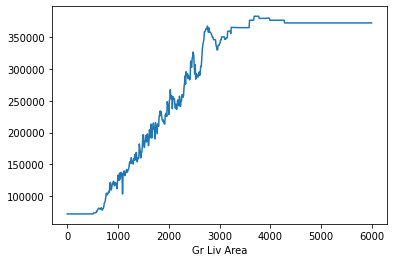

In [18]:
y_new_pred.index = X_new["Gr Liv Area"]
y_new_pred.plot.line()

Now let's put all the pieces together and overlay this regression function on top of a scatterplot of the training data.

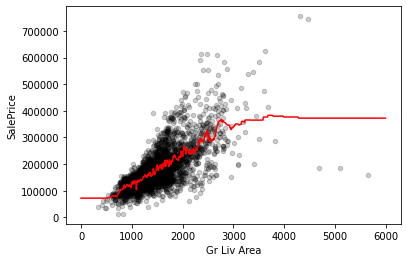

In [19]:
# Make a scatterplot of the training data
housing.plot.scatter(x="Gr Liv Area", y="SalePrice", color="black", alpha=.2)

# Add the predictions as a red line on this scatterplot
y_new_pred.plot.line(color="red")

Notice how rough the 30-nearest neighbors regression function looks. In particular, look at the right half of the graph where the training data is sparse. The regression function is a step function in this range. That is because the value of the prediction changes only when the identities of the 30-nearest neighbors change. Houses with a square footage between 4500 and 6000 all have the same 30 nearest neighbors in the training data, so the prediction is constant in that range.

# Exercises Part 1

## Exercise 1

Plot the $k$-nearest neighbors regression function for predicting sale price from just its square footage for $k=5, 30, 100$. How does the regression function change as $k$ increases?

**Hint:** To do this we'll need to modify the function above to take an argument being the number of neighbors.

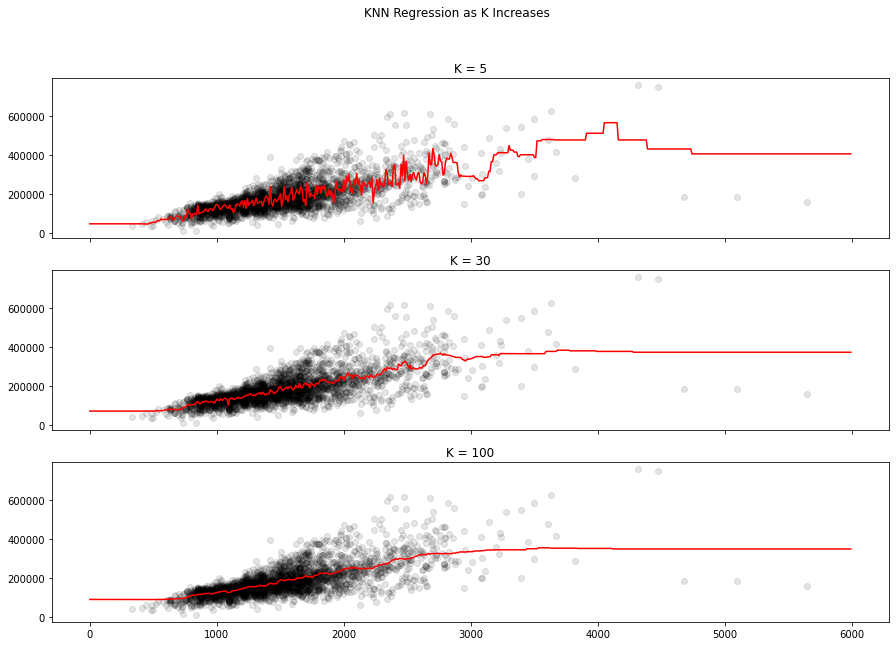

In [20]:
# K Nearest Neighbors

def get_KNN_prediction(x_new, k):
    dists = np.sqrt(((X_train - x_new)**2).sum(axis=1))
    inds_sorted = dists.sort_values().index[:k]
    return y_train.loc[inds_sorted].mean()

# List of K Values
kList = [5,30,100]

# X and Y Values
X_train = housing[["Gr Liv Area"]]
y_train = housing["SalePrice"]


X_new = pd.DataFrame()
X_new["Gr Liv Area"] = np.arange(0, 6000, 10)

# Matplotlib fig
fig, axs = plt.subplots(3, sharex = True)
fig.set_size_inches(15,10)
fig.suptitle("KNN Regression as K Increases")

# Plot regression line for each value of K
for i,k in enumerate(kList):
  y_new_pred = X_new.apply(lambda x: get_KNN_prediction(x, k), axis=1)
  y_new_pred.index = X_new["Gr Liv Area"]
  axs[i].scatter(housing["Gr Liv Area"], housing["SalePrice"], color="black", alpha=.1)
  axs[i].plot(y_new_pred, color = "red")
  axs[i].set_title("K = " + str(k))

plt.show()


**Written Answer:**
*The regression function gets smoother and more consistent as the number 'k' of neighbors increases.*

## Exercise 2.

You would like to predict how much a male diner will tip on a bill of \$40.00 on a Sunday. Build a $k$-nearest neighbors model to answer this question, using the Tips dataset (`../data/tips.csv`) as your training data.

In [21]:
# Assume 30 nearest neighbors - could be variable
k = 30

# Read in dataset
df_tips = pd.read_csv('../data/tips.csv')
# Notice 'sex', 'smoker', 'day', 'time' are categorical variables

# Convert training data to continuous or one-hot categorical, only using focus attributes
features = ["total_bill", "sex", "day"]
X_train = pd.get_dummies(df_tips[features])


# Isolate target variable for regression
y_train = df_tips[['tip']]

# Create 'new' data point
x_new = pd.Series(index = X_train.columns, dtype = float)
x_new["total_bill"] = 40.00
x_new["sex_Male"] = 1
x_new["day_Sun"] = 1
x_new.fillna(0, inplace = True)


# Scale data
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_sc = (X_train - X_train_mean) / X_train_std
x_new_sc = (x_new - X_train_mean) / X_train_std

# Calculate distance, find k nearest neighbors
dists = np.sqrt(((X_train_sc - x_new_sc) ** 2).sum(axis=1))
i_nearest = dists.sort_values()[:k].index

# Find average of k nearest neighbors
print("Predicted tip: $%.2f" %(y_train.loc[i_nearest].mean()))
# The model predicts a tip of $3.90

Predicted tip: $3.90


**BONUS BONUS BONUS Exercise (2 points).** We visualized the $k$-nearest neighbors regression function above, in the special case where there is only one feature. It is also possible to visualize a regression function in the case where there are two features, using a heat map, where the two axes represent the two features and the color represents the label.

Make a heat map that shows the 30-nearest neighbors regression function when there are two features in the model: square footage (`Gr Liv Area`) and number of bedrooms (`Bedroom AbvGr`).

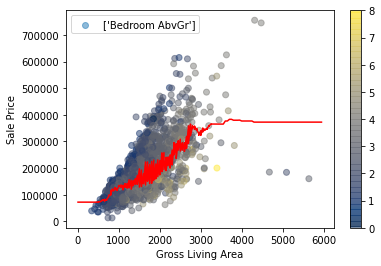

In [22]:
# X and Y Data Values
X_train = housing[["Gr Liv Area", "Bedroom AbvGr"]]
y_train = housing["SalePrice"]

# Make the scatter plot
plt.scatter(c = housing["Bedroom AbvGr"], y = housing["SalePrice"], x = housing["Gr Liv Area"],   cmap = "cividis", alpha = 0.5, label = ["Bedroom AbvGr"] )
plt.xlabel("Gross Living Area")
plt.ylabel("Sale Price")
plt.colorbar()
plt.legend()

# Do KNN Regression

def get_KNN_prediction(x_new, k):
    dists = np.sqrt(((X_train - x_new)**2).sum(axis=1))
    inds_sorted = dists.sort_values().index[:k]
    return y_train.loc[inds_sorted].mean()

# Generate New Data Points
X_new = pd.DataFrame()
for g in range(0, 6000, 50):
  for b in range(0, 6000, 50):
    new_row = {"Gr Liv Area": g, "Bedroom AbvGr": b}
    X_new = X_new.append(new_row, ignore_index = True)

# Apply KNN (k = 30) Regression to New Data
y_new_pred = X_new.apply(lambda x: get_KNN_prediction(x, 30), axis=1)
y_new_pred.index = X_new["Gr Liv Area"]

# Plot Results
plt.plot(y_new_pred, color = "red")



  

# Part 2: The Scikit-Learn API

In the previous section, we implemented $k$-nearest neighbors from scratch. Now we will see how to implement it using [Scikit-Learn](http://scikit-learn.org/), a Python library that makes it easy to train and use machine learning models. All models are trained and used in the exact same way:

1. Declare the model.
2. Fit the model to training data, consisting of both features $X$ and labels $y$.
3. Use the model to predict the labels for new values of the features.

Let's take a look at how we would use this API to train a model on the Ames housing data set to predict the 2011 price of the Old Town house from the previous section. Scikit-Learn assumes that the data has already been completely converted to  quantitative variables and that the variables have already been standardized (if desired). The code below reads in the data and does the necessary preprocessing. 

(All of this code is copied from the previous section. Read the code, and if you are not sure what a particular line does, refer back to the previous section.)

In [23]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing = pd.read_csv("../data/ames.tsv", sep="\t")

housing["Date Sold"] = housing["Yr Sold"] + housing["Mo Sold"] / 12
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Date Sold",
            "Neighborhood"]
X_train = pd.get_dummies(housing[features])
y_train = housing["SalePrice"]

x_new = pd.Series(index=X_train.columns, dtype=float)
x_new["Lot Area"] = 9000
x_new["Gr Liv Area"] = 1400
x_new["Full Bath"] = 2
x_new["Half Bath"] = 1
x_new["Bedroom AbvGr"] = 3
x_new["Year Built"] = 1980
x_new["Date Sold"] = 2011
x_new["Neighborhood_OldTown"] = 1
x_new.fillna(0, inplace=True)

X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_sc = (X_train - X_train_mean) / X_train_std
x_new_sc = (x_new - X_train_mean) / X_train_std

X_train_sc

,Lot Area,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Year Built,Date Sold,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,2.743912,0.309212,-1.024618,-0.755074,0.176064,-0.375473,1.620757,-0.09821,-0.058511,-0.101692,...,-0.157561,-0.245025,-0.297967,-0.129033,-0.233061,-0.211064,-0.257308,-0.133073,-0.158694,-0.090862
1,0.187065,-1.194223,-1.024618,-0.755074,-1.032058,-0.342410,1.684822,-0.09821,-0.058511,-0.101692,...,-0.157561,-0.245025,-0.297967,-0.129033,-0.233061,-0.211064,-0.257308,-0.133073,-0.158694,-0.090862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,-0.017503,-0.218968,-1.024618,-0.755074,-1.032058,0.087408,-1.518428,-0.09821,-0.058511,-0.101692,...,-0.157561,-0.245025,-0.297967,-0.129033,-0.233061,-0.211064,-0.257308,-0.133073,-0.158694,-0.090862
2929,-0.066107,0.989715,0.783894,1.234464,0.176064,0.715604,-1.069973,-0.09821,-0.058511,-0.101692,...,-0.157561,-0.245025,-0.297967,-0.129033,-0.233061,-0.211064,-0.257308,-0.133073,-0.158694,-0.090862


`X_train_sc` is a matrix of all numbers, which is the form that Scikit-Learn expects. Now let's see how to use Scikit-Learn to fit a $k$-nearest neighbors model to this data.

In [24]:
from sklearn.neighbors import KNeighborsRegressor

# Step 1: Declare the model.
model = KNeighborsRegressor(n_neighbors=30)

# Step 2: Fit the model to training data.
model.fit(X_train_sc, y_train)

# Step 3: Use the model to predict for new observations.
# Scikit-Learn expects 2-dimensional arrays, so we need to 
# turn the Series into a DataFrame with 1 row.
X_new_sc = x_new_sc.to_frame().T
model.predict(X_new_sc)

array([132343.33333333])

This is the exact same prediction that we got by implementing $k$-nearest neighbors manually (look back up to verify this is the case).

In the case of training a machine learning model to predict for a single observation, Scikit-Learn may seem like overkill. In fact, the above Scikit-Learn code was 5 lines, whereas our implementation of $k$-nearest neighbors in the previous section was only 4 lines. However, learning Scikit-Learn will pay off as the problems become more complex.

## Preprocessing in Scikit-Learn

We constructed `X_train_sc` and `x_new_sc` above using just basic `pandas` operations. But it is also possible to have Scikit-Learn do this preprocessing for us. The preprocessing objects in Scikit-Learn all follow the same basic pattern:

1. First, the preprocessing object has to be "fit" to a data set.
2. The `.transform()` method actually processes the data. This method can be called repeatedly on multiple data sets and is guaranteed to process each data set in exactly the same way.

It might not be obvious why it is necessary to first "fit" the preprocessing object to a data set before using it to process data. Hopefully, the following examples will make this clear.

### Example 1: Dummy Encoding

Instead of using `pd.get_dummies()`, we can do dummy encoding in Scikit-Learn using the `DictVectorizer` tool. There is one catch: `DictVectorizer` expects the data as a list of dictionaries, not as a `DataFrame`. But each row of a `DataFrame` can be represented as a dictionary, where the keys are the column names and the values are the data. `Pandas` provides a convenience function, `.to_dict()`, that converts a `DataFrame` into a list of dictionaries.

In [25]:
X_train_dict = housing[features].to_dict(orient="records")
X_train_dict[:2]

[{'Lot Area': 31770,
  'Gr Liv Area': 1656,
  'Full Bath': 1,
  'Half Bath': 0,
  'Bedroom AbvGr': 3,
  'Year Built': 1960,
  'Date Sold': 2010.4166666666667,
  'Neighborhood': 'NAmes'},
 {'Lot Area': 11622,
  'Gr Liv Area': 896,
  'Full Bath': 1,
  'Half Bath': 0,
  'Bedroom AbvGr': 2,
  'Year Built': 1961,
  'Date Sold': 2010.5,
  'Neighborhood': 'NAmes'}]

Now we pass this list to `DictVectorizer`, which will expand each categorical variable (e.g., "Neighborhood") into dummy variables. When the vectorizer is fit to the training data, it will learn all of the possible categories for each categorical variable so that when `.transform()` is called on different data sets, the same dummy variables will be returned (and in the same order). This is important for us because we need to apply the encoding to two data sets, the training data and the new observation, and we want to be sure that the same dummy variables appear in both.

In [26]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)

X_train = vec.transform(X_train_dict)
x_new_dict = {
    "Lot Area": 9000,
    "Gr Liv Area": 1400,
    "Full Bath": 2,
    "Half Bath": 1,
    "Bedroom AbvGr": 3,
    "Year Built": 1980,
    "Date Sold": 2011,
    "Neighborhood": "OldTown"
}
X_new = vec.transform([x_new_dict])

X_train

array([[3.00000000e+00, 2.01041667e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.96000000e+03],
       [2.00000000e+00, 2.01050000e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.96100000e+03],
       [3.00000000e+00, 2.01050000e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.95800000e+03],
       ...,
       [3.00000000e+00, 2.00658333e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.99200000e+03],
       [2.00000000e+00, 2.00633333e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.97400000e+03],
       [3.00000000e+00, 2.00691667e+03, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.99300000e+03]])

### Example 2: Scaling

We can also use Scikit-Learn to scale our data. The `StandardScaler` function standardizes data, but there are other functions, such as `Normalizer` and `MinMaxScaler`, that normalize and apply min-max scaling to the data, respectively. 

In the previous section, we standardized both the training data and the new observation with respect to the _training data_. To specify that the standardization should be with respect to the training data, we fit the scaler to the training data. Then, we use the scaler to transform both the training data and the new observation.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_new_sc = scaler.transform(X_new)

X_train_sc

array([[ 0.17609421,  1.62103356, -1.02479289, ..., -0.15872127,
        -0.0908778 , -0.37553701],
       [-1.03223376,  1.68510949, -1.02479289, ..., -0.15872127,
        -0.0908778 , -0.34246845],
       [ 0.17609421,  1.68510949, -1.02479289, ..., -0.15872127,
        -0.0908778 , -0.44167415],
       ...,
       [ 0.17609421, -1.32645923, -1.02479289, ..., -0.15872127,
        -0.0908778 ,  0.68265709],
       [-1.03223376, -1.51868702, -1.02479289, ..., -0.15872127,
        -0.0908778 ,  0.0874229 ],
       [ 0.17609421, -1.07015551,  0.7840283 , ..., -0.15872127,
        -0.0908778 ,  0.71572565]])

## Putting It All Together

The following example shows a complete pipeline: from reading in the raw data and processing it, to fitting a machine learning model and using it for prediction.

In [28]:
# Read in the data.
housing = pd.read_csv("../data/ames.tsv", sep="\t")

# Define the features.
housing["Date Sold"] = housing["Yr Sold"] + housing["Mo Sold"] / 12
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Date Sold",
            "Neighborhood"]

# Define the training data.
# Represent the features as a list of dicts.
X_train_dict = housing[features].to_dict(orient="records")
X_new_dict = [{
    "Lot Area": 9000,
    "Gr Liv Area": 1400,
    "Full Bath": 2,
    "Half Bath": 1,
    "Bedroom AbvGr": 3,
    "Year Built": 1980,
    "Date Sold": 2011,
    "Neighborhood": "OldTown"
}]
y_train = housing["SalePrice"]

# Dummy encoding
vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
X_new = vec.transform(X_new_dict)

# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_new_sc = scaler.transform(X_new)

# K-Nearest Neighbors Model
model = KNeighborsRegressor(n_neighbors=30)
model.fit(X_train_sc, y_train)
model.predict(X_new_sc)

array([132343.33333333])

# Exercises Part 2



## Exercise 3

(This exercise is identical to Exercise 2 from the previous section, except it asks you to use Scikit-Learn.) You would like to predict how much a male diner will tip on a bill of \$40.00 on a Sunday. Use Scikit-Learn to build a $k$-nearest neighbors model to answer this question, using the Tips dataset (`../data/tips.csv`) as your training data.

In [29]:
from sklearn.feature_extraction import DictVectorizer
# Read in Data
df_tips = pd.read_csv('../data/tips.csv')


# Define Features, Convert to Dict for DictVectorizer
features = ["total_bill", "sex", "day"]
X_train_dict = df_tips[features].to_dict(orient="records")

# Create New Data Point as Dict
X_new_dict = [{
    "total_bill" : 40.00,
    "sex": "Male",
    "day": "Sun"
}]

y_train = df_tips["tip"]

# Encode Categorical Variables as Vectors Using DictVectorizer
vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
X_new = vec.transform(X_new_dict)

# Standard Scale Data
stdscaler = StandardScaler()
stdscaler.fit(X_train)
X_train_scaled = stdscaler.transform(X_train)
X_new_scaled = stdscaler.transform(X_new)

# Do KNN Regression
knn = KNeighborsRegressor(n_neighbors=30)
knn.fit(X_train_scaled, y_train)
prediction =  knn.predict(X_new_scaled)

print("KNN Predicts a tip of $%.2f"%(prediction[0]))

# Predicts $3.90

KNN Predicts a tip of $3.90


*This model predicts a tip of $3.90$. The other KNN model predicted $3.92 which is very close, so this is a feasible answer*

**When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)**